In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
import tensorflow as tf
import re

Лабораторная работа №10. ОСНОВЫ ОБРАБОТКИ ЕСТЕСТВЕННОГО ЯЗЫКА (NLP). ЗАДАЧА ТЕМАТИЧЕСКОГО МОДЕЛИРОВАНИЯ

ЗАДАНИЕ
1. Для выполнения задания используйте датасет с данными о спаме (https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset).
2. *** Самостоятельно реализовать BoW, TF-IDF.
3. Решить задачу классификации с понижением размерности.
4. Решить задачу тематического моделирования с помощью LDA.

# Преобразвоание датасета

In [2]:
df = pd.read_csv('../data/spam.csv', encoding = 'latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.drop(columns = ['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], inplace = True)
df.rename(columns = {'v1': 'Target', 'v2': 'Message'}, inplace = True)
df.head()

,Target,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
dict = {'ham': 0,
        'spam': 1}
df['Target'] = df['Target'].map(dict)
df.head()

,Target,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Предобработка данных

In [5]:
def clean(Text):
    msg = re.sub('[^a-zA-Z0-9]',' ',Text)
    msg = msg.lower()
    msg = msg.split()
    msg = ' '.join(msg)
    return msg

In [6]:
df.loc[:,'Clean_message'] = df['Message'].apply(clean)

In [7]:
df.head()

,Target,Message,Clean_message
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...


## Токенизация

In [8]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [9]:
def tokens(s):
    doc = nlp(s)
    tokens = [token for token in doc]
    return tokens

In [10]:
df.loc[:, "Token_message"] = df["Clean_message"].apply(tokens)

In [11]:
df.head()

,Target,Message,Clean_message,Token_message
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,..."


In [12]:
def toStr(tokenlist):
    wordlist = [str(token) for token in tokenlist]
    return(wordlist)

In [13]:
df["Token_message"] = df["Token_message"].apply(toStr)

## Удаление стоп-слов

In [14]:
df.head()

,Target,Message,Clean_message,Token_message
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,..."


In [15]:
stopwords = nlp.Defaults.stop_words

In [16]:
def stop_word(words):
    doc = nlp(" ".join(words))
    filtred_text = [token for token in doc if token.lower_ not in stopwords]
    return filtred_text

In [17]:
df.loc[:, "Filtred_message"] = df["Token_message"].apply(stop_word)

In [18]:
df.head()

,Target,Message,Clean_message,Token_message,Filtred_message
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[jurong, point, crazy, available, bugis, n, gr..."
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, early, hor, u, c]"
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, don, t, think, goes, usf, lives]"


In [19]:
df["Filtred_message"] = df["Filtred_message"].apply(toStr)

## Лемматизация

In [20]:
def lemma_word(words):
    doc = nlp(" ".join(words))
    lemmas = [token.lemma_ for token in doc]
    return lemmas

In [21]:
df.loc[:, "Lemmatized_message"] = df["Filtred_message"].apply(lemma_word)

In [22]:
df.head()

,Target,Message,Clean_message,Token_message,Filtred_message,Lemmatized_message
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[jurong, point, crazy, available, bugis, n, gr...","[jurong, point, crazy, available, bugis, n, gr..."
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, early, hor, u, c]","[u, dun, early, hor, u, c]"
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, don, t, think, goes, usf, lives]","[nah, don, t, think, go, usf, life]"


## Векторизация

In [23]:
corpus = []
for i in df['Lemmatized_message']:
    message = ' '.join([row for row in i])
    corpus.append(message)

In [24]:
corpus[:5]

['jurong point crazy available bugis n great world la e buffet cine get amore wat',
 'ok lar joke wif u oni',
 'free entry wkly comp win fa cup final tkts st text fa receive entry question std txt rate t c s apply s',
 'u dun early hor u c',
 'nah don t think go usf life']

### BoW

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
count_vectorizer = CountVectorizer(ngram_range=(1,3))

X_bow = count_vectorizer.fit_transform(corpus)
X_bow.shape

(5572, 58060)

In [27]:
X_bow.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### TD-IDF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
tfidf = TfidfVectorizer(ngram_range=(1,3))
X_tfidf = tfidf.fit_transform(corpus)
X_tfidf.shape

(5572, 58060)

In [30]:
X_tfidf.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

## Подготовка к обучению

In [31]:
y = df['Target']

### Понижение размерности

In [32]:
skb_bow = SelectKBest(k=75)
X_bow_rd = skb_bow.fit_transform(X_bow, y)
X_bow_rd.shape

(5572, 75)

In [33]:
skb_tfidf = SelectKBest(k=75)
X_tfidf_rd = skb_tfidf.fit_transform(X_tfidf, y)
X_tfidf_rd.shape

(5572, 75)

### Разбиение

In [34]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow_rd,y, test_size=0.2)

In [35]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf_rd, y, test_size=0.2)

## Обучение

In [36]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes' : GaussianNB(),
    'KNN classifier': KNeighborsClassifier(n_neighbors=2, metric='minkowski', weights="distance")
}

### BoW

In [1]:
n_classifiers = len(classifiers)

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X_train_bow.toarray(), np.ravel(y_train_bow))
    y_pred = classifier.predict(X_test_bow.toarray())
    print(classification_report(y_test_bow, y_pred), '\n\n')

NameError: name 'classifiers' is not defined

### TD-IDF

In [38]:
n_classifiers = len(classifiers)

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X_train_tfidf.toarray(), np.ravel(y_train_tfidf))
    y_pred = classifier.predict(X_test_tfidf.toarray())
    print(confusion_matrix(y_test_tfidf, y_pred))
    print(classification_report(y_test_tfidf, y_pred), '\n\n')

[[968   1]
 [115  31]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       969
           1       0.97      0.21      0.35       146

    accuracy                           0.90      1115
   macro avg       0.93      0.61      0.65      1115
weighted avg       0.90      0.90      0.87      1115
 


[[956  13]
 [ 30 116]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       969
           1       0.90      0.79      0.84       146

    accuracy                           0.96      1115
   macro avg       0.93      0.89      0.91      1115
weighted avg       0.96      0.96      0.96      1115
 


[[959  10]
 [ 23 123]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       969
           1       0.92      0.84      0.88       146

    accuracy                           0.97      1115
   macro avg       0.95      0.92      0.93      1115

## Тематическое моделирование

In [39]:
from sklearn.decomposition import LatentDirichletAllocation

### BoW

In [40]:
lda_bow = LatentDirichletAllocation(n_components=5, max_iter=20,
                                learning_method='online',
                                learning_offset=50)

In [41]:
lda_top_bow = lda_bow.fit_transform(X_bow)

In [42]:
print(lda_top_bow.shape)

(5572, 5)


In [43]:
print("Document 0: ")
for i,topic in enumerate(lda_top_bow[0]):
  print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  0.5461524131314093 %
Topic  1 :  0.5415117433294605 %
Topic  2 :  0.5512870885646101 %
Topic  3 :  0.5409614529049954 %
Topic  4 :  97.82008730206954 %


In [44]:
for i, comp in enumerate(lda_bow.components_):
    vocab_comp = zip(count_vectorizer.get_feature_names_out(), comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
lor ok da not prize ur day wat win contact 

Topic 1: 
not tell want pls know go love miss send good 

Topic 2: 
text stop free min reply txt phone mobile send number 

Topic 3: 
ur free txt know tone text win new www week 

Topic 4: 
gt lt lt gt come ll get good love sorry time 



### TD-IDF

In [45]:
lda_tfidf = LatentDirichletAllocation(n_components=5, max_iter=20,
                                learning_method='online',
                                learning_offset=50)

In [46]:
lda_top_tfidf = lda_tfidf.fit_transform(X_tfidf)

In [47]:
print("Document 5000: ")
for i,topic in enumerate(lda_top_tfidf[5000]):
  print("Topic ",i,": ",topic*100,"%")

Document 5000: 
Topic  0 :  4.523569506562041 %
Topic  1 :  4.525596298538075 %
Topic  2 :  81.79082690725956 %
Topic  3 :  4.531458071929292 %
Topic  4 :  4.62854921571104 %


In [48]:
for i, comp in enumerate(lda_tfidf.components_):
    vocab_comp = zip(tfidf.get_feature_names_out(), comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
free mobile ur text message tone late sir send txt 

Topic 1: 
day text great win wish box birthday stop www txt 

Topic 2: 
ok home think go good know get day love lor 

Topic 3: 
gt lt come lt gt not want send time pick tell 

Topic 4: 
later ll sorry ll later sorry ll sorry ll later wat lor work go 



# Забавное

In [49]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def draw_word_cloud(index):
  imp_words_topic=""
  comp=lda_tfidf.components_[index]
  vocab_comp = zip(tfidf.get_feature_names_out(), comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

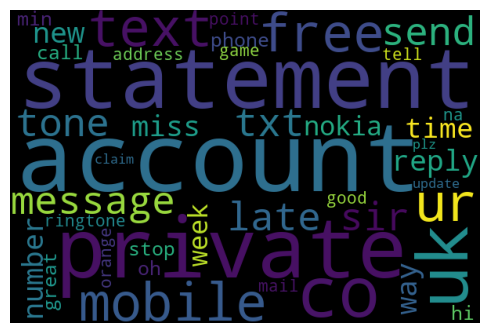

In [50]:
draw_word_cloud(0)

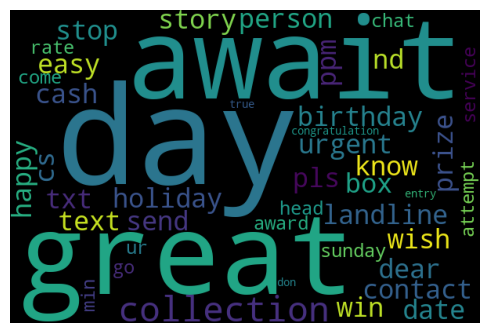

In [51]:
draw_word_cloud(1)

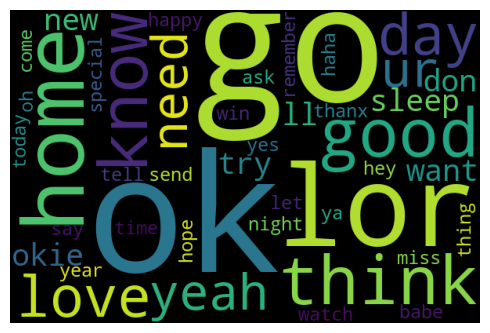

In [52]:
draw_word_cloud(2)

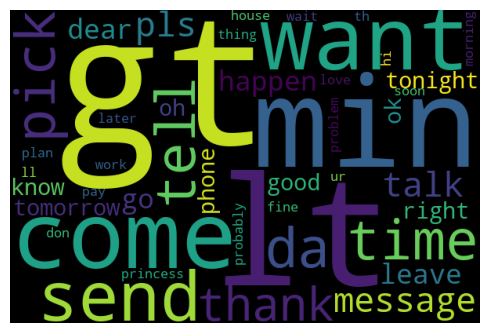

In [53]:
draw_word_cloud(3)

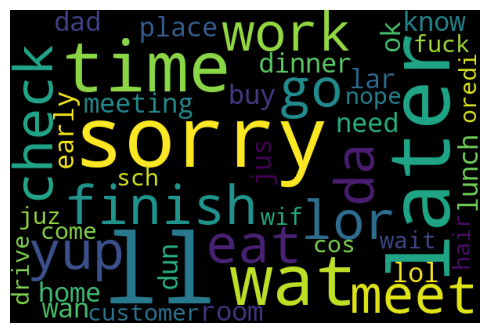

In [54]:
draw_word_cloud(4)